In [1]:
from __future__ import division, print_function, unicode_literals
import os
import re
import logging
import operator
import itertools
from itertools import islice
from collections import Counter, deque, defaultdict
from datetime import timedelta, date
from cytoolz import count, take, concatv, dissoc, sliding_window, unique
import pandas as pd
import numpy as np
import spacy
from scipy import spatial
import liwc
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.gridspec as mgridspec
plt.style.use('newsprint.mplstyle')

In [2]:
pd.options.display.max_colwidth = 300 # defaults to 50

In [3]:
logging.basicConfig(level=logging.DEBUG)

In [4]:
# local modules
from presidents import logger, parse_date, tzinfos, calculate_election_day, jaccard_index, root
from presidents.readers import read_strings
logger.setLevel(logging.INFO)

In [5]:
from presidents.models import standard_stopwords, nlp, parse, is_word

In [6]:
from presidents.scraping import tapp
# reload(tapp)

In [7]:
import presidents.text; reload(presidents.text)
from presidents.text import tokenize, token_counts, token_freqs, context_spans, context_tokens

## Data loading

In [8]:
nlp.meta

{u'author': u'Explosion AI',
 u'description': u'General-purpose English model, with tagging, parsing, entities and word vectors',
 u'email': u'contact@explosion.ai',
 u'lang': u'en',
 u'license': u'CC BY-SA 3.0',
 u'name': u'core_web_md',
 u'spacy_version': u'>=1.7.0,<2.0.0',
 u'url': u'https://explosion.ai',
 u'version': u'1.2.1'}

In [9]:
presidents_lookup = dict(tapp.presidents)

In [10]:
liwc_parse_token, liwc_category_names = liwc.load_token_parser('/usr/local/data/liwc_2007.dic')

In [11]:
def liwc_scores(token_counts):
    '''
    Calculate the length-normalized LIWC category scores for the document described by the bag-of-words
    `token_counts`, which should be a mapping from lowercase strings to integer occurrences of those strings.
    
    Returns 0 for categories with no matches.
    '''
    length = sum(token_counts.values())
    counter = Counter()
    for token, count in token_counts.items():
        for category in liwc_parse_token(token):
            counter[category] += count
    return {category: (counter[category] / length) for category in liwc_category_names}

In [12]:
def cdi(token_counts):
    scores = liwc_scores(token_counts)
    categorical = sum(scores[k] for k in ('article', 'preps'))
    dynamic = sum(scores[k] for k in ('auxverb', 'ipron', 'ppron', 'adverb', 'conj', 'negate'))
    return categorical - dynamic

In [13]:
# %%time
# all_tapp_papers = list(tapp.read_local_cache())
# print('Loaded {} "papers" from TAPP database'.format(len(all_tapp_papers)))

In [14]:
def is_speech(paper):
    title_is_blacklisted = paper['title'].startswith((
        'Press Release',
        'Memorandum',
        'Statement by the Press Secretary',
        'Notice',
        'Proclamation',
        'Statement of Administration Policy',
        'Executive Order',
        'Fact Sheet',
        'Press Gaggle', # not so sure about this one, perhaps too broad
    ))
    # exclude really short papers (like some that are just an embedded YouTube video)
    text_is_empty = len(paper['text']) < 140
    return not title_is_blacklisted and not text_is_empty

In [15]:
# tag=False, parse=False, entity=False =>     29s
# tag=True,  parse=False, entity=False =>  1m 35s
# tag=False, parse=True,  entity=False =>  3m 53s
# tag=False, parse=False, entity=True  =>  2m 29s
# tag=True,  parse=True,  entity=True  => 20m 24s (!)

## Important Dates and Binning 

In [16]:
def bin_papers(papers):
    '''
    Group a single president's papers into 4 bins.
    Yields (bin_description, start_date, end_date, n_papers, joined_text) tuples,
    1 for each bin, so 4 total.
    '''
    # we use the paper timestamp / date multiple times, so we compute it once for each paper, first.
    papers = [dict(paper, date=parse_date(paper['timestamp']).date()) for paper in papers]
    # this raises an exception if there is no inaugural address in the list of papers
    inauguration_date = sorted(paper['date'] for paper in papers if 'Inaugural Address' in paper['title'])[0]
    election_date = calculate_election_day(inauguration_date)
    bins = [
        ('100 days before Election', 
         election_date - timedelta(days=100), 
         election_date),
        ('Election to Inaugural', 
         election_date, 
         inauguration_date),
        ('First 100 days in Office', 
         inauguration_date, 
         inauguration_date + timedelta(days=100)),
        ('Second 100 days in Office', 
         inauguration_date + timedelta(days=100), 
         inauguration_date + timedelta(days=200)),
    ]
    for description, start_date, end_date in bins:
        bin_papers = [paper for paper in papers if start_date < paper['date'] <= end_date]
        bin_text = ' '.join(paper['text'] for paper in bin_papers)
        yield description, start_date, end_date, len(bin_papers), bin_text

In [17]:
def _read_president_papers(president):
    papers = [paper for paper in tapp.read_president_papers(president) if is_speech(paper)]
    logger.info('Read {} papers from disk for president {}'.format(len(papers), president))
    return papers

_cached_president_papers = {}
def load_president_papers(president):
    if president not in _cached_president_papers:
        _cached_president_papers[president] = _read_president_papers(president)
    return _cached_president_papers[president]

In [18]:
def _read_president_doc(president):
    '''
    For `president` (an index; 35 = Kennedy; 44 = Obama),
    return a spaCy Doc instance
    with user_data: president, n_papers
    '''
    papers = load_president_papers(president)
    bins = list(bin_papers(papers))
    # combine bins into a single document
    text = ' '.join(bin_text for _, _, _, _, bin_text in bins)
    n_papers = sum(bin_n_papers for _, _, _, bin_n_papers, _ in bins)
    start_date = min(bin_start_date for _, bin_start_date, _, _, _ in bins)
    end_date = max(bin_end_date for _, _, bin_end_date, _, _ in bins) 
    doc = nlp(text)
    doc.user_data = dict(start_date=start_date, 
                         end_date=end_date, 
                         n_papers=n_papers)
    return doc

_cached_president_doc = {}
def load_president_doc(president):
    if president not in _cached_president_doc:
        logger.info('Loading doc from disk for president {}'.format(president))
        _cached_president_doc[president] = _read_president_doc(president)
    return _cached_president_doc[president]

In [19]:
def _read_president_bindocs(president):
    '''
    For `president` (an index; 35 = Kennedy; 44 = Obama),
    return a tuple (id, name, docs)
    where docs is a list of spaCy Doc instances
    with user_data: bin, start_date, end_date, n_papers
    '''
    papers = load_president_papers(president)
    logger.info('Reading bindocs from {} papers for president {}'.format(len(papers), president))
    def iter_bindocs():
        for description, start_date, end_date, n_papers, text in bin_papers(papers):
            doc = nlp(text)
            doc.user_data = dict(description=description, 
                                 start_date=start_date, 
                                 end_date=end_date, 
                                 n_papers=n_papers)
            yield doc
    return list(iter_bindocs())

_cached_president_bindocs = {}
def load_president_bindocs(president):
    if president not in _cached_president_bindocs:
        logger.info('Loading bindocs from disk for president {}'.format(president))
        _cached_president_bindocs[president] = _read_president_bindocs(president)
    return _cached_president_bindocs[president]

In [20]:
def sim_description(*docs):
    '''
    docs should be a list of bindocs 
    (spacy.doc.Doc instances with a description field in user_data)
    '''
    return ' ↔ '.join(doc.user_data['description'] for doc in docs)

In [21]:
# all_presidents = range(46)
# last_2_presidents = [44, 45]
# last_10_presidents = all_presidents[-10:]

## Descriptive statistics for bins

In [22]:
%%time
def create_bin_stats_df(presidents):
    columns = pd.Index(['president_id', 'president', 'bin', 'start_date', 'end_date', 'n_documents', 'n_tokens', 'n_types'])
    def iter_rows():
        for president in presidents:
            name = presidents_lookup[president]
            for bindoc in load_president_bindocs(president):
                bin_data = [bindoc.user_data[k] for k in ['description', 'start_date', 'end_date', 'n_papers']]
                yield [president, name] + bin_data + [len(bindoc), len(token_counts(bindoc))]
    return pd.DataFrame(iter_rows(), columns=columns)

df_bin_stats = create_bin_stats_df([41, 42, 43, 44, 45]).set_index(['president_id', 'president', 'bin'])

INFO:presidents:Loading bindocs from disk for president 41
INFO:presidents:Read 5014 papers from disk for president 41
INFO:presidents:Reading bindocs from 5014 papers for president 41
INFO:presidents:Loading bindocs from disk for president 42
INFO:presidents:Read 12503 papers from disk for president 42
INFO:presidents:Reading bindocs from 12503 papers for president 42
INFO:presidents:Loading bindocs from disk for president 43
INFO:presidents:Read 9186 papers from disk for president 43
INFO:presidents:Reading bindocs from 9186 papers for president 43
INFO:presidents:Loading bindocs from disk for president 44
INFO:presidents:Read 7856 papers from disk for president 44
INFO:presidents:Reading bindocs from 7856 papers for president 44
INFO:presidents:Loading bindocs from disk for president 45
INFO:presidents:Read 736 papers from disk for president 45
INFO:presidents:Reading bindocs from 736 papers for president 45


In [23]:
df_bin_stats['types/tokens'] = df_bin_stats.n_types / df_bin_stats.n_tokens
df_bin_stats

start_date  \
president_id president          bin                                     
41           George Bush        100 days before Election   1988-07-31   
                                Election to Inaugural      1988-11-08   
                                First 100 days in Office   1989-01-20   
                                Second 100 days in Office  1989-04-30   
42           William J. Clinton 100 days before Election   1992-07-26   
                                Election to Inaugural      1992-11-03   
                                First 100 days in Office   1993-01-20   
                                Second 100 days in Office  1993-04-30   
43           George W. Bush     100 days before Election   2000-07-30   
                                Election to Inaugural      2000-11-07   
                                First 100 days in Office   2001-01-20   
                                Second 100 days in Office  2001-04-30   
44           Barack Obama       100 days before Election   2008-07-27   
                                Election to Inaugural      2008-11-04   
                                First 100 days in Office   2009-01-20   
                                Second 100 days in Office  2009-04-30   
45           Donald J. Trump    100 days before Election   2016-07-31   
                                Election to Inaugural      2016-11-08   
                                First 100 days in Office   2017-01-20   
                                Second 100 days in Office  2017-04-30   

                                                             end_date  \
president_id president          bin                                     
41           George Bush        100 days before Election   1988-11-08   
                                Election to Inaugural      1989-01-20   
                                First 100 days in Office   1989-04-30   
                                Second 100 days in Office  1989-08-08   
42           William J. Clinton 100 days before Election   1992-11-03   
                                Election to Inaugural      1993-01-20   
                                First 100 days in Office   1993-04-30   
                                Second 100 days in Office  1993-08-08   
43           George W. Bush     100 days before Election   2000-11-07   
                                Election to Inaugural      2001-01-20   
                                First 100 days in Office   2001-04-30   
                                Second 100 days in Office  2001-08-08   
44           Barack Obama       100 days before Election   2008-11-04   
                                Election to Inaugural      2009-01-20   
                                First 100 days in Office   2009-04-30   
                                Second 100 days in Office  2009-08-08   
45           Donald J. Trump    100 days before Election   2016-11-08   
                                Election to Inaugural      2017-01-20   
                                First 100 days in Office   2017-04-30   
                                Second 100 days in Office  2017-08-08   

                                                           n_documents  \
president_id president          bin                                      
41           George Bush        100 days before Election             3   
                                Election to Inaugural               12   
                                First 100 days in Office           368   
                                Second 100 days in Office          429   
42           William J. Clinton 100 days before Election             1   
                                Election to Inaugural                6   
                                First 100 days in Office           423   
                                Second 100 days in Office          485   
43           George W. Bush     100 days before Election             1   
                               

In [24]:
%%time
def create_stats_df(presidents):
    columns = pd.Index(['president_id', 'president', 'start_date', 'end_date', 'n_documents', 'n_tokens', 'n_types'])
    def iter_rows():
        for president in presidents:
            president_data = [president, presidents_lookup[president]]
            doc = load_president_doc(president)
            doc_data = [doc.user_data[k] for k in ['start_date', 'end_date', 'n_papers']]
            yield president_data + doc_data + [len(doc), len(token_counts(doc))]
    return pd.DataFrame(iter_rows(), columns=columns)

df_stats = create_stats_df([41, 42, 43, 44, 45]).set_index(['president_id', 'president'])

INFO:presidents:Loading doc from disk for president 41
INFO:presidents:Loading doc from disk for president 42
INFO:presidents:Loading doc from disk for president 43
INFO:presidents:Loading doc from disk for president 44
INFO:presidents:Loading doc from disk for president 45


In [25]:
df_stats['types/tokens'] = df_stats.n_types / df_stats.n_tokens
df_stats

,,start_date,end_date,n_documents,n_tokens,n_types,types/tokens
president_id,president,,,,,,
41,George Bush,1988-07-31,1989-08-08,812,794483,19411,0.024432
42,William J. Clinton,1992-07-26,1993-08-08,915,2273566,22991,0.010112
43,George W. Bush,2000-07-30,2001-08-08,769,1033892,19759,0.019111
44,Barack Obama,2008-07-27,2009-08-08,862,1678236,22799,0.013585
45,Donald J. Trump,2016-07-31,2017-08-08,588,1020555,18555,0.018181


## Calculating vector-space distance per bin

Between each of president's bins and a target keyword/document.

In [26]:
war_doc = nlp('''war 
wars military warfare conflict army troops soldiers battle fighting battles
forces invasion Battlefield casualties terrorism soldier civil wartime combat
waged terror enemy civilians allies destruction genocide fought armies Iraq
political hostilities weapons struggle peace fight civilian aftermath waging
siege atrocities armed occupation revolution violence force conflicts propaganda
generals naval bloodshed terrorist rebellion bloody uprising nations imperialism
terrorists nation bombing horrors killed insurgency attack government death
politics rebels crisis killing confrontation Holocaust threat WW2 communist fear
slavery revolt crimes history democracy wounded WWII Empire world massacre
destroyed brutal assassination warriors homeland enemies violent communism
battlefields strife conquest guerrilla hero evil
''')
freedom_doc = nlp('''freedom 
liberty rights freedoms liberties democracy equality public democratic
citizens justice civil constitutional laws independence law political government
dignity privilege society responsibility interests moral legal religious citizen
intellectual policy constitution sovereignty authority conscience respect peace
religion governmental faith advocate politics judicial contrary nor concerned
regard privacy restrictions welfare not fundamental autonomy nation morality
social advocating advocates belief concern tyranny citizenship virtue matters
state legitimate protections activism ideals enforce ownership inalienable human
sense policies mandate granted desire national violate country defend regardless
uphold allowed economic reform obligation own humanity principle slavery
governments CANNOT struggle federal necessity truth education legislation
opposition purpose''')

In [27]:
def create_spacy_distance_df(presidents, target_docs):
    columns = pd.Index(['president', 'bin', 'target', 'similarity'])
    def iter_rows():
        for president in presidents:
            bindocs = load_president_bindocs(president)
            for bindoc in bindocs:
                for target_doc in target_docs:
                    similarity = bindoc.similarity(target_doc)
                    yield presidents_lookup[president], bindoc.user_data['description'], target_doc[0].text, similarity
    return pd.DataFrame(iter_rows(), columns=columns)

df_spacy_distance = create_spacy_distance_df([44, 45], [war_doc, freedom_doc])

In [28]:
df = df_spacy_distance.pivot_table(columns='target', index=['president', 'bin'])
df

similarity          
target                                       freedom       war
president       bin                                           
Barack Obama    100 days before Election    0.704783  0.573195
                Election to Inaugural       0.713903  0.575615
                First 100 days in Office    0.705173  0.567737
                Second 100 days in Office   0.712053  0.573249
Donald J. Trump 100 days before Election    0.703777  0.584168
                Election to Inaugural       0.692529  0.564982
                First 100 days in Office    0.688033  0.561965
                Second 100 days in Office   0.703650  0.579638

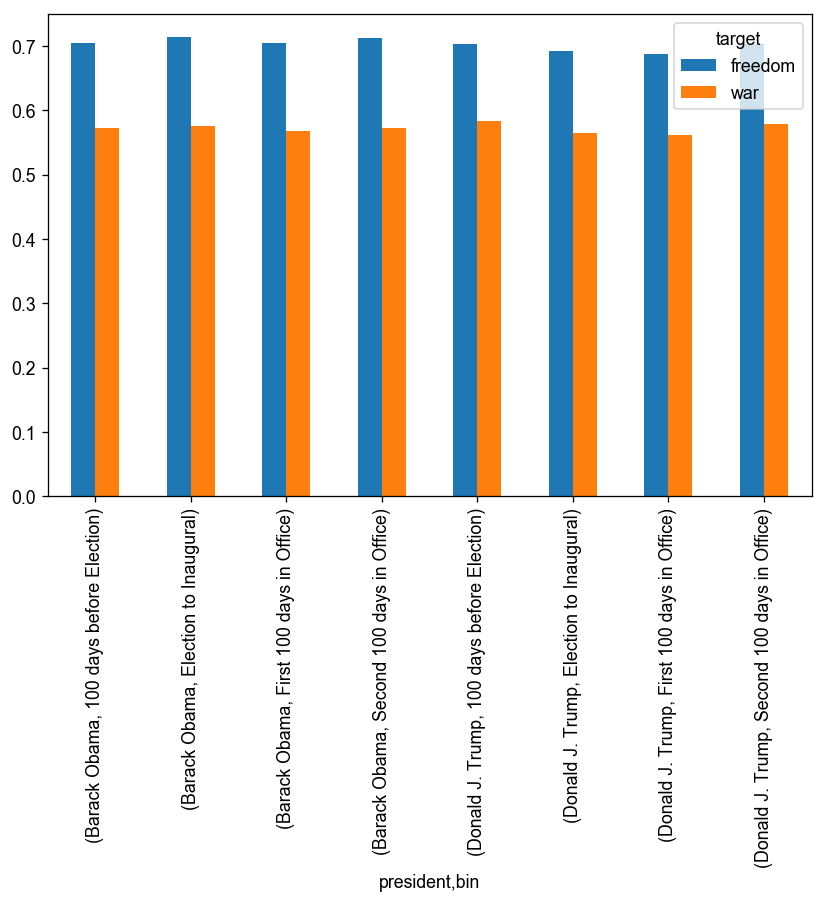

In [29]:
df.similarity.plot(kind='bar')

## Keyword context similarity

In [31]:
def create_keyword_similarity_df(presidents, keyword_docs, target_docs, preceding_tokens, subsequent_tokens):
    columns = pd.Index(['president', 'keyword', 'target', 'similarity'])
    def iter_rows():
        for president in presidents:
            name = presidents_lookup[president]
            doc = load_president_doc(president)
            # baseline
            for target_doc in target_docs:
                yield name, 'overall', target_doc[0].text, target_doc.similarity(doc)
            # keyword matches
            for keyword_doc in keyword_docs:
                keyword_re = re.compile(r'\b' + keyword_doc.text + r'\b', re.I)
                for pre_span, _, post_span in context_spans(doc, keyword_re, preceding_tokens, subsequent_tokens):
                    for target_doc in target_docs:
                        similarity = np.mean([target_doc.similarity(pre_span), 
                                              target_doc.similarity(post_span)])
                        yield name, keyword_doc.text, target_doc[0].text, similarity
    return pd.DataFrame(iter_rows(), columns=columns)

keyword_docs = [nlp('North Korea'), nlp('Russia'), nlp('Japan')]
# target_docs = [nlp('war'), nlp('freedom')] # non-seeded
target_docs = [war_doc, freedom_doc]
keyword_similarity_df = create_keyword_similarity_df([44, 45], keyword_docs, target_docs, 50, 50)

Text(0,0.5,u'Similarity (0 = completely different)')

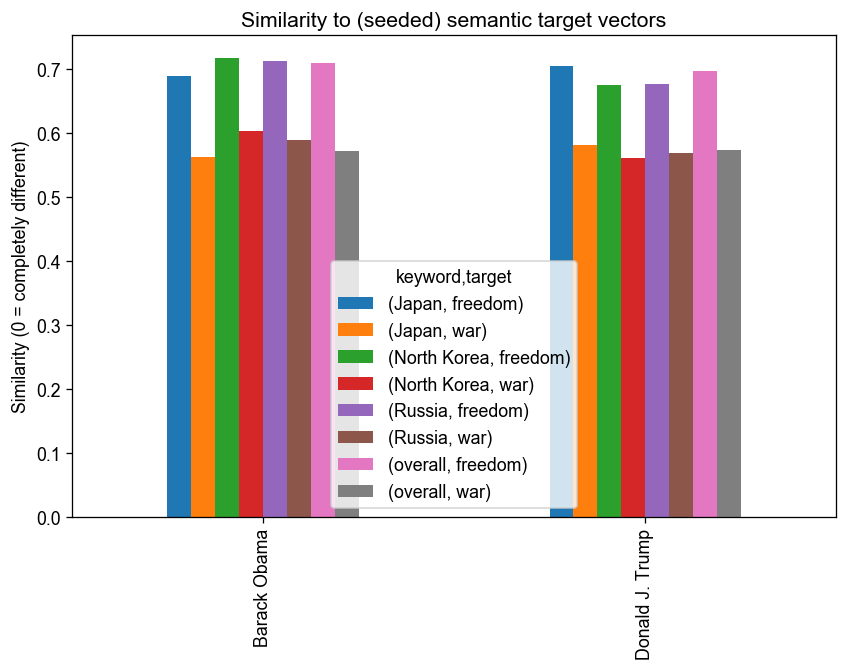

In [32]:
df = keyword_similarity_df.pivot_table(index=['president'], columns=['keyword', 'target'])
df.similarity.plot(kind='bar')
plt.title('Similarity to (seeded) semantic target vectors')
plt.xlabel('')
plt.ylabel('Similarity (0 = completely different)')

## spaCy inter-bin similarity 

In [33]:
def create_spacy_similarity_df(presidents):
    columns = pd.Index(['president_id', 'president', 'bins', 'similarity'])
    def iter_rows():
        for president in presidents:
            name = presidents_lookup[president]
            bindocs = load_president_bindocs(president)
            for bindoc1, bindoc2 in sliding_window(2, bindocs):
                similarity = bindoc1.similarity(bindoc2)
                description = sim_description(bindoc1, bindoc2)
                yield president, name, description, similarity
    return pd.DataFrame(iter_rows(), columns=columns)

df_spacy_similarity = create_spacy_similarity_df([41, 42, 43, 44, 45])

In [34]:
df = df_spacy_similarity.pivot_table(values='similarity', index=['president_id', 'president'], columns='bins')
df = df.reset_index('president_id', drop=True)
df

bins,100 days before Election ↔ Election to Inaugural,Election to Inaugural ↔ First 100 days in Office,First 100 days in Office ↔ Second 100 days in Office
president,,,
George Bush,0.998706,0.996625,0.999375
William J. Clinton,0.982335,0.996745,0.999592
George W. Bush,0.990895,0.996257,0.998190
Barack Obama,0.996761,0.998646,0.999781
Donald J. Trump,0.996756,0.998632,0.998778


Text(0.5,1,u"Similarity in spaCy's 300-dimension distributional vector space")

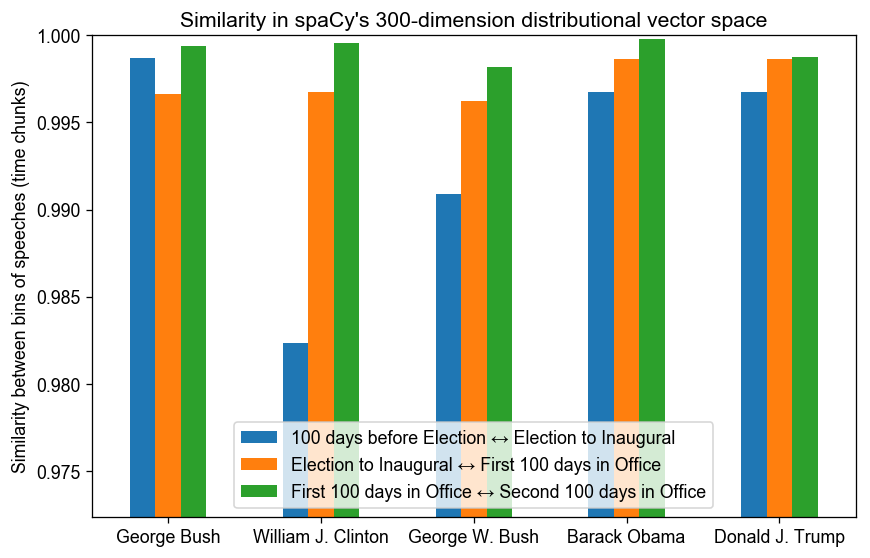

In [35]:
df.plot(kind='bar')
ymin = df.min().min()
plt.ylim(ymin - 0.01, 1.0)
plt.xlabel('')
plt.xticks(rotation=0)
plt.legend(loc='lower center')
plt.ylabel('Similarity between bins of speeches (time chunks)')
plt.title("Similarity in spaCy's 300-dimension distributional vector space")
# plt.savefig('Recent_presidents_pre-post-inaugural-100d-spacy-similarity.pdf')

## Type overlap

In [36]:
def create_types_tokens_df(presidents):
    columns = pd.Index(['president', 'bin', 'types', 'tokens'])
    def iter_rows():
        for president in presidents:
            for bindoc in load_president_bindocs(president):
                bin_token_counts = token_counts(bindoc)
                yield (presidents_lookup[president], bindoc.user_data['description'], 
                       len(bin_token_counts), sum(bin_token_counts.values()))
    return pd.DataFrame(iter_rows(), columns=columns)

df_types_tokens = create_types_tokens_df([44, 45])

In [134]:
# df = df_types_tokens.pivot_table(values=['types', 'tokens'], index=['president'], columns='bin')
# df.plot(kind='bar')
# # plt.legend(loc='upper center')
# plt.legend(loc='best')
# plt.xticks(rotation=90)
# plt.xlabel('')
# plt.title('Tokens')

In [38]:
def create_type_overlap_df(presidents):
    columns = pd.Index(['president', 'bins', 'overlap'])
    def iter_rows():
        for president in presidents:
            name = presidents_lookup[president]
            bindocs = load_president_bindocs(president)
            for bindoc1, bindoc2 in sliding_window(2, bindocs):
                overlap = jaccard_index(token_counts(bindoc1).keys(), token_counts(bindoc2).keys())
                description = sim_description(bindoc1, bindoc2)
                yield name, description, overlap
    return pd.DataFrame(iter_rows(), columns=columns)

df_type_overlap = create_type_overlap_df([44, 45])
df_type_overlap

,president,bins,overlap
0,Barack Obama,100 days before Election ↔ Election to Inaugural,0.414975
1,Barack Obama,Election to Inaugural ↔ First 100 days in Office,0.425609
2,Barack Obama,First 100 days in Office ↔ Second 100 days in Office,0.473616
3,Donald J. Trump,100 days before Election ↔ Election to Inaugural,0.274795
4,Donald J. Trump,Election to Inaugural ↔ First 100 days in Office,0.196342
5,Donald J. Trump,First 100 days in Office ↔ Second 100 days in Office,0.427243


In [129]:
df = df_type_overlap.pivot_table(values='overlap', index=['president'], columns='bins')
df

bins,100 days before Election ↔ Election to Inaugural,Election to Inaugural ↔ First 100 days in Office,First 100 days in Office ↔ Second 100 days in Office
president,,,
Barack Obama,0.414975,0.425609,0.473616
Donald J. Trump,0.274795,0.196342,0.427243


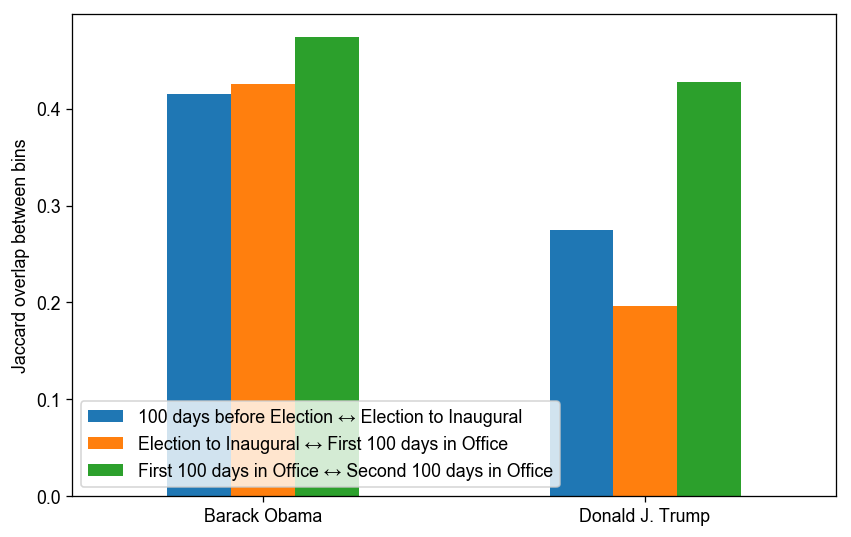

In [130]:
df.plot(kind='bar')
plt.xticks(rotation=0)
plt.xlabel('')
plt.ylabel('Jaccard overlap between bins')
plt.legend(loc='lower left')

## LIWC Categorical-Dynamic Index

In [41]:
def create_cdi_df(presidents):
    columns = pd.Index(['president_id', 'president', 'bin', 'cdi'])
    def iter_rows():
        for president in presidents:
            name = presidents_lookup[president]
            bindocs = load_president_bindocs(president) 
            for bindoc in bindocs:
                bin_token_counts = token_counts(bindoc)
                yield president, name, bindoc.user_data['description'], cdi(bin_token_counts)
    return pd.DataFrame(iter_rows(), columns=columns)

df_cdi = create_cdi_df([41, 42, 43, 44, 45])

In [42]:
df = df_cdi.pivot_table(values='cdi', index=['president_id', 'president'], columns='bin')
df = df.reset_index('president_id', drop=True)
df

bin,100 days before Election,Election to Inaugural,First 100 days in Office,Second 100 days in Office
president,,,,
George Bush,-0.144292,-0.136537,-0.078718,-0.051028
William J. Clinton,-0.012034,-0.136342,-0.123628,-0.120266
George W. Bush,-0.138458,-0.131166,-0.075146,-0.037746
Barack Obama,-0.146568,-0.132685,-0.133198,-0.117602
Donald J. Trump,-0.139978,-0.183807,-0.159117,-0.119828


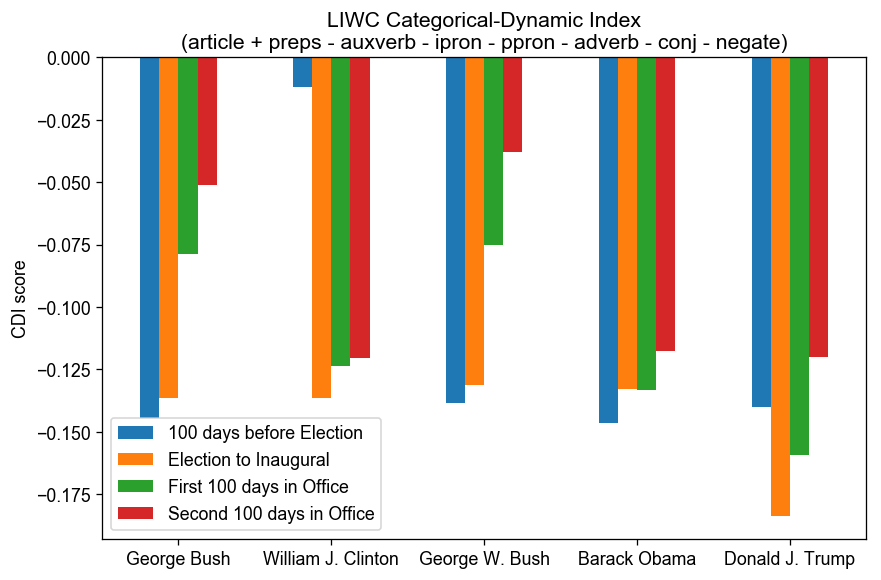

In [43]:
df.plot(kind='bar')
plt.xticks(rotation=0)
plt.legend(loc='best')
plt.xlabel('')
plt.ylabel('CDI score')
plt.title('LIWC Categorical-Dynamic Index\n(article + preps - auxverb - ipron - ppron - adverb - conj - negate)');
# plt.savefig('Recent_presidents_pre-post-inaugural-100d-CDI.pdf')

## Token/type ratios

In [44]:
def token_to_type_ratio(counts):
    type_count = len(counts)
    token_count = sum(counts.values())
    if type_count > 0:
        return token_count / type_count
    # for our purposes, 0/0 = 1
    return 1.0

### Bin-wise token/type ratios

In [123]:
def create_token_type_ratio_df(presidents):
    columns = pd.Index(['president', 'bin', 'tokens/types'])
    def iter_rows():
        for president in presidents:
            name = presidents_lookup[president]
            bindocs = load_president_bindocs(president) 
            for bindoc in bindocs:
                bin_token_counts = token_counts(bindoc)
                yield name, bindoc.user_data['description'], token_to_type_ratio(bin_token_counts)
    return pd.DataFrame(iter_rows(), columns=columns).set_index('president')

df_token_type_ratio = create_token_type_ratio_df([44, 45])
df_token_type_ratio

,bin,tokens/types
president,,
Barack Obama,100 days before Election,30.731313
Barack Obama,Election to Inaugural,21.753328
Barack Obama,First 100 days in Office,35.519516
Barack Obama,Second 100 days in Office,30.538144
Donald J. Trump,100 days before Election,25.690345
Donald J. Trump,Election to Inaugural,7.522002
Donald J. Trump,First 100 days in Office,29.610286
Donald J. Trump,Second 100 days in Office,21.536955


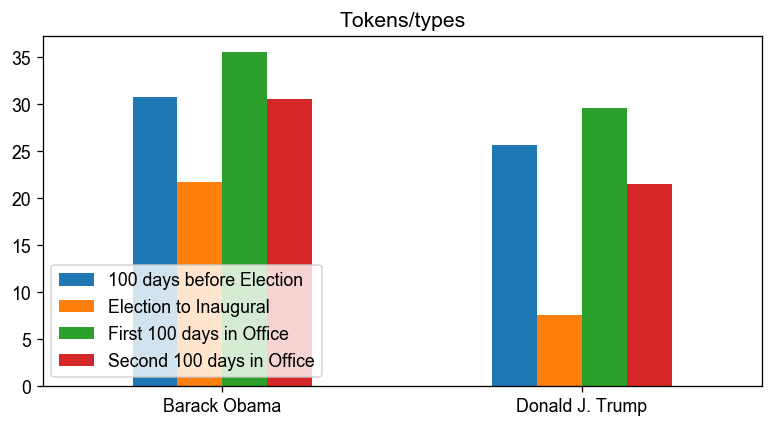

In [127]:
df = df_token_type_ratio.pivot_table(values='tokens/types', index=['president'], columns='bin')
df.plot(kind='bar', figsize=(8, 4))
plt.xticks(rotation=0)
plt.xlabel('')
plt.title('Tokens/types')
plt.legend(loc='lower left')

### Token/type trends

In [47]:
def create_token_type_trend_df(presidents, max_token_counts):
    columns = pd.Index(['president', 'tokens', 'types'])
    def iter_rows():
        for president in presidents:
            name = presidents_lookup[president]
            doc = load_president_doc(president)
            for max_token_count in max_token_counts:
                if max_token_count < len(doc):
                    span = doc[0:max_token_count]
                    #span_token_counts = token_counts(span) # but there is no Span#count_by(...) :(
                    span_token_counts = Counter(token.lower_ for token in span)
                    span_types = len(span_token_counts)
                    yield name, max_token_count, span_types
    return pd.DataFrame(iter_rows(), columns=columns)

max_token_counts = (range(1, 10, 1) +
                    range(10, 100, 10) +
                    range(100, 1000, 100) +
                    range(1000, 10000, 1000) +
                    range(10000, 100000, 10000) +
                    range(100000, 1000000, 100000) +
                    range(1000000, 10000000, 1000000))
df_token_type_trend = create_token_type_trend_df([41, 42, 43, 44, 45], max_token_counts)

Text(0.5,1,u'Tokens-types trends')

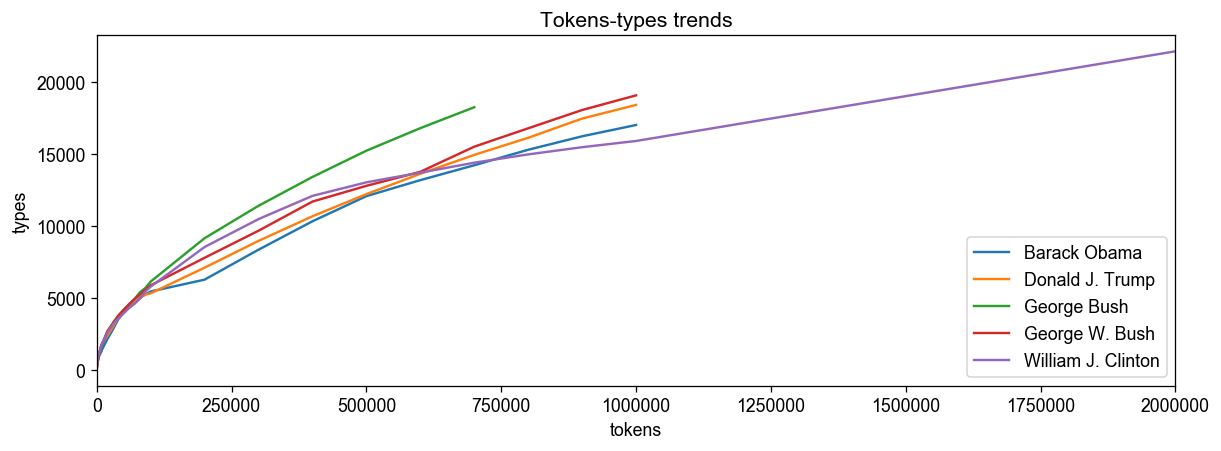

In [128]:
fig, ax = plt.subplots(figsize=(12, 4))
for label, df_group in df_token_type_trend.groupby('president'):
    df_group.plot('tokens', 'types', ax=ax, label=label)
plt.xlabel('tokens')
plt.ylabel('types')
plt.title('Tokens-types trends')

## LIWC Inter-bin Similarity

In [120]:
def create_liwc_similarity_df(presidents, selected_liwc_category_names):
    columns = pd.Index(['president_id', 'president', 'bins', 'similarity'])
    def iter_rows():
        for president in presidents:
            name = presidents_lookup[president]
            bindocs = load_president_bindocs(president)
            for bindoc1, bindoc2 in sliding_window(2, bindocs):
                liwc1, liwc2 = [liwc_scores(token_counts(bindoc)) for bindoc in [bindoc1, bindoc2]]
                values1, values2 = [[liwc[k] for k in selected_liwc_category_names] for liwc in [liwc1, liwc2]]
                similarity = 1 - spatial.distance.cosine(values1, values2)
                description = sim_description(bindoc1, bindoc2)
                yield president, name, description, similarity
    return pd.DataFrame(iter_rows(), columns=columns)

all_liwc_category_names = liwc_category_names
emo_liwc_category_names = ['posemo', 'negemo']
cdi_liwc_category_names = ['article', 'preps', 'auxverb', 'ipron', 'ppron', 'adverb', 'conj', 'negate']

selected_liwc_category_names = all_liwc_category_names
df_liwc_similarity = create_liwc_similarity_df([41, 42, 43, 44, 45], selected_liwc_category_names)

In [121]:
df = df_liwc_similarity.pivot_table(values='similarity', index=['president_id', 'president'], columns='bins')
df = df.reset_index('president_id', drop=True)

Text(0.5,1,u'Similarity in 64-category LIWC vector space\n(normalized by word count)')

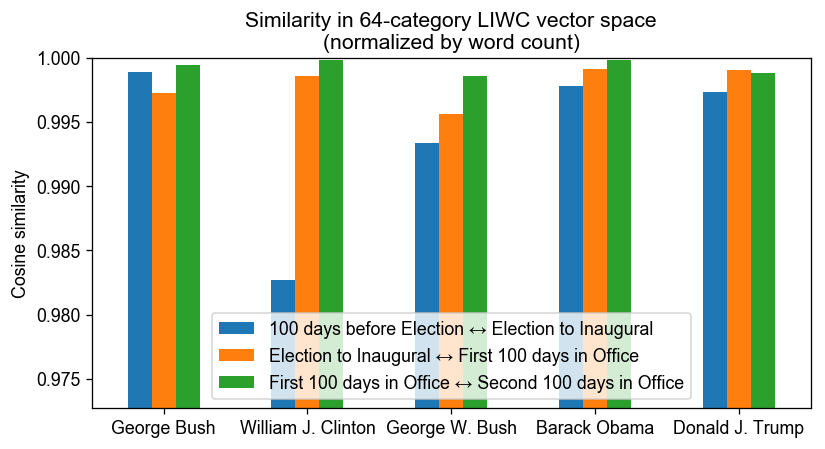

In [122]:
df.plot(kind='bar', figsize=(8, 4))
ymin = df.min().min()
plt.ylim(ymin - 0.01, 1.0)
plt.xlabel('')
plt.ylabel('Cosine similarity')
plt.xticks(rotation=0)
plt.legend(loc='lower center')
plt.title("Similarity in {}-category LIWC vector space\n(normalized by word count)".format(len(selected_liwc_category_names)))
# plt.savefig('Recent_presidents_pre-post-inaugural-100d-liwc-similarity.pdf')

## Word Clouds !!!

In [52]:
# pip install -U wordcloud
from wordcloud import WordCloud

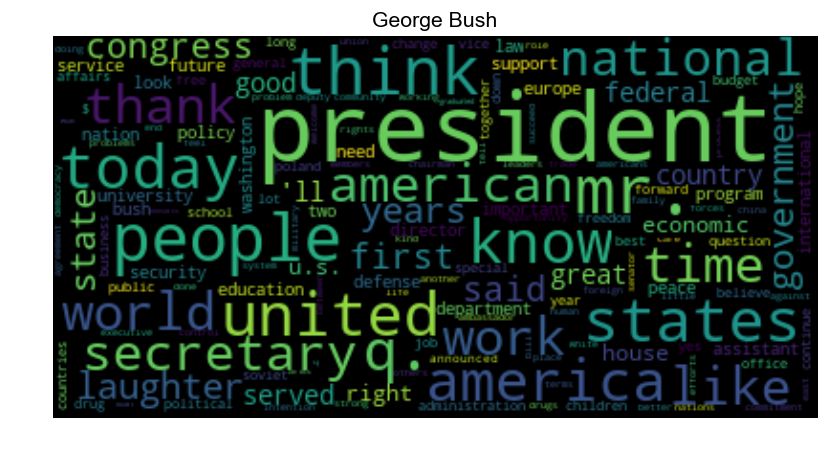

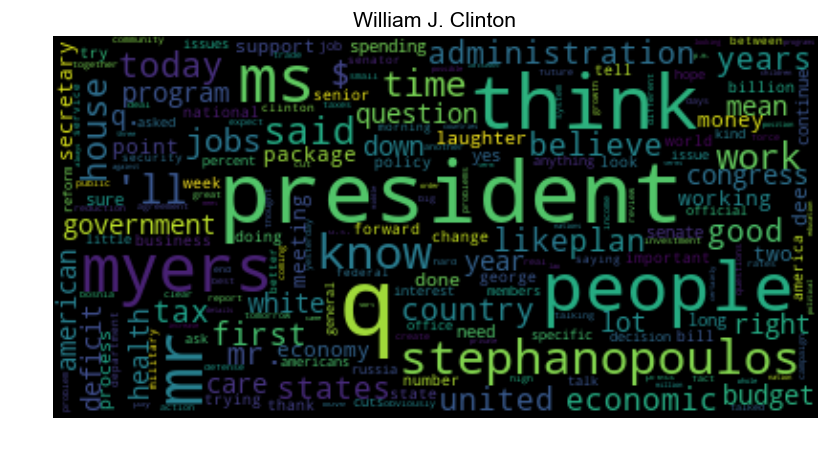

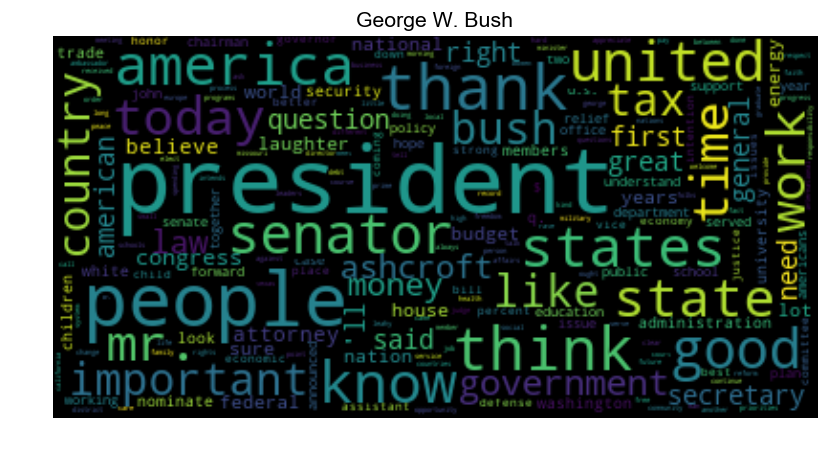

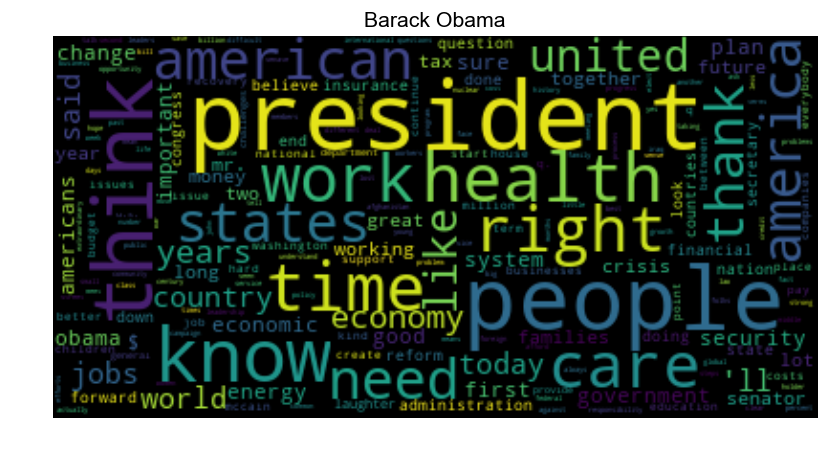

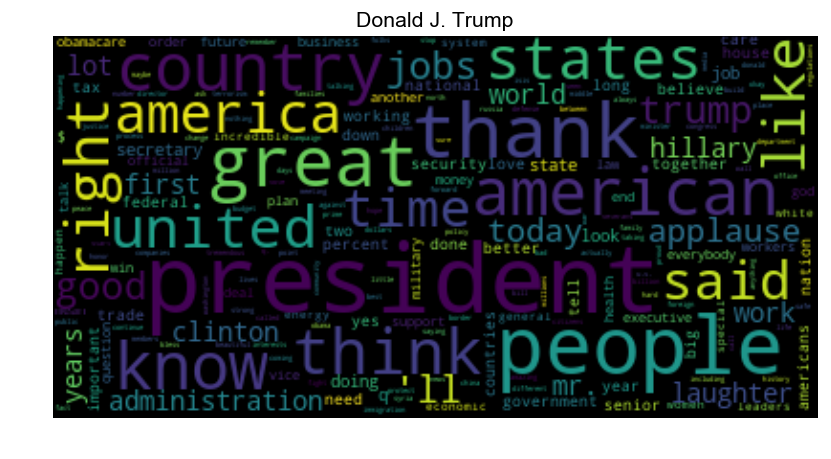

In [53]:
def display_wordclouds(presidents):
    for president in presidents:
        name = presidents_lookup[president]             
        doc = load_president_doc(president)
        frequencies = token_freqs(doc)
        frequencies = dissoc(frequencies, *standard_stopwords)
        wordcloud = WordCloud(max_font_size=50).generate_from_frequencies(frequencies)
        plt.figure()
        plt.title(name)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
display_wordclouds([41, 42, 43, 44, 45])

## Fancy textacy analysis

In [54]:
from textacy.keyterms import most_discriminating_terms

In [55]:
def iter_president_terms(president):
    for paper in load_president_papers(president):
        # all we need is tokenization
        doc = nlp(paper['text'], tag=False, parse=False, entity=False)
        yield [token.text for token in doc]

In [56]:
%%time
terms1 = list(iter_president_terms(44))
terms2 = list(iter_president_terms(45))

CPU times: user 44.1 s, sys: 7.82 s, total: 51.9 s
Wall time: 59.3 s


In [57]:
%%time
top_n_terms = most_discriminating_terms(terms1 + terms2, [True]*len(terms1) + [False]*len(terms2),
                                        max_n_terms=1000, top_n_terms=100)

CPU times: user 1min 9s, sys: 1.3 s, total: 1min 10s
Wall time: 1min 11s


In [58]:
pd.DataFrame(zip(*top_n_terms), columns=['Obama', 'Trump'])

,Obama,Trump
0,Michelle,Trump
1,extraordinary,Hillary
2,kids,–
3,recession,incredible
4,progress,honor
5,still,border
6,21st,disaster
7,challenges,Great
8,century,really
9,afford,immigration


## Basic syntax

In [59]:
def word_candidates(tokens):
    '''
    Convert tokens into a (potentially shorter) list of lowercase, word-like, unicode strings.
    '''
    for token in tokens:
        # convert to spaCy Lexeme if needed
        if not isinstance(token, (spacy.lexeme.Lexeme, spacy.tokens.Token)):
            token = nlp.vocab[token]
        if not (token.is_oov or token.is_punct or token.is_space or token.is_digit):
            text = token.text.lower()
            if len(text) > 1 or text in {'a', 'i'}:
                yield text

google_1t_10k_path = os.path.join(root, 'stopwords', 'google-1t-10000.txt')
google_1t_10k_strings = [bytestring.decode('utf-8') for bytestring in read_strings(google_1t_10k_path)]
top_2000_words = list(take(2000, unique(word_candidates(google_1t_10k_strings))))
top_2000_words_set = set(top_2000_words)
top_5000_words = list(take(5000, unique(word_candidates(google_1t_10k_strings))))
top_5000_words_set = set(top_5000_words)

In [61]:
def uses_only_2000_most_common_english_words(span):
    span_words = set(word_candidates(span))
    return span_words.issubset(top_2000_words_set)

In [62]:
def uses_only_5000_most_common_english_words(span):
    span_words = set(word_candidates(span))
    return span_words.issubset(top_5000_words_set)

## Feature functions

A feature function has a descriptive and unique `__name__` attribute.
It takes a spaCy Doc and returns a scalar value.

In [78]:
def create_featurized_df(presidents, feature_functions):
    def iter_rows():
        for president in presidents:
            name = presidents_lookup[president]
            doc = load_president_doc(president)
            doc_token_counts = token_counts(doc)
            n_documents = doc.user_data['n_papers']
            for feature_function in feature_functions:
                yield president, name, n_documents, feature_function.__name__, feature_function(doc)
    return pd.DataFrame(iter_rows(), columns=['president_id', 'president', 'n_documents', 'feature', 'value'])

In [69]:
# token/type features
def n_tokens(doc):
    return len(doc)

def n_types(doc):
    return len(doc.count_by(spacy.attrs.LOWER))

token_type_feature_functions = [n_tokens, n_types]

In [70]:
# part-of-speech features
def n_words(doc):
    return count(token for token in doc if not (token.is_stop or token.is_punct or token.is_space))

def n_nouns(doc):
    return doc.count_by(spacy.attrs.POS)[nlp.vocab.strings['NOUN']]

def n_verbs(doc):
    return doc.count_by(spacy.attrs.POS)[nlp.vocab.strings['VERB']]

pos_feature_functions = [n_words, n_nouns, n_verbs]

In [71]:
# sentence features
def n_sents(doc):
    return count(doc.sents)
    
def n_short_sents(doc):
    return count(1 for sent in doc.sents if len(sent) < 10)
    
def n_sents_using_only_5000_mcew(doc):
    return count(1 for sent in doc.sents if uses_only_5000_most_common_english_words(sent))

def _uses_only_own_N_most_common_words_func(own_doc, N):
    '''
    Helper for the n_sents_using_only_own_* feature functions below.
    '''
    own_N_most_common_words = set(dict(Counter(word_candidates(own_doc)).most_common(N)).keys())
    def check(span):
        span_words = set(word_candidates(span))
        return span_words.issubset(own_N_most_common_words)
    return check

def n_sents_using_only_own_2000_mcw(doc):
    uses_only_own_2000_most_common_words = _uses_only_own_N_most_common_words_func(doc, 2000)
    return count(1 for sent in doc.sents if uses_only_own_2000_most_common_words(sent))

def n_sents_using_only_own_2000_mcw_or_2000_mcew(doc):
    # it gets messy :(
    uses_only_own_2000_most_common_words = _uses_only_own_N_most_common_words_func(doc, 2000)
    return count(1 for sent in doc.sents if 
                 (uses_only_2000_most_common_english_words(sent) or
                  uses_only_own_2000_most_common_words(sent)))

sentence_feature_functions = [
    n_sents,
    n_short_sents,
    n_sents_using_only_5000_mcew,
    n_sents_using_only_own_2000_mcw,
    n_sents_using_only_own_2000_mcw_or_2000_mcew]

In [72]:
# (other) complexity features
def avg_sent_length(doc):
    return np.mean([len(sent) for sent in doc.sents])

def avg_word_length(doc):
    return np.mean([len(token) for token in doc])

def avg_token_prob(doc):
    return np.mean([token.prob for token in doc])

complexity_feature_functions = [avg_sent_length, avg_word_length, avg_token_prob]

In [79]:
%%time
df_syntactic_counts = create_featurized_df([41, 42, 43, 44, 45], 
                                           token_type_feature_functions + 
                                           pos_feature_functions + 
                                           sentence_feature_functions + 
                                           complexity_feature_functions)

CPU times: user 2min 4s, sys: 3.25 s, total: 2min 7s
Wall time: 2min 12s


In [84]:
df = df_syntactic_counts.pivot_table(values='value', 
                                     index=['president_id', 'president', 'n_documents'], 
                                     columns='feature').reset_index('president_id', drop=True).reset_index('n_documents')
df

feature,n_documents,avg_sent_length,avg_token_prob,avg_word_length,n_nouns,n_sents,n_sents_using_only_5000_mcew,n_sents_using_only_own_2000_mcw,n_sents_using_only_own_2000_mcw_or_2000_mcew,n_short_sents,n_tokens,n_types,n_verbs,n_words
president,,,,,,,,,,,,,,
George Bush,812,19.271874,-7.339621,4.080778,122297.0,41225.0,12407.0,13719.0,14049.0,10933.0,794483.0,19446.0,123720.0,669457.0
William J. Clinton,915,14.158199,-7.073009,3.876235,368347.0,160583.0,79126.0,95386.0,96668.0,77026.0,2273566.0,23036.0,409661.0,1890972.0
George W. Bush,769,18.363653,-7.236373,4.045262,159592.0,56301.0,17500.0,22002.0,22431.0,15978.0,1033892.0,19800.0,174000.0,874799.0
Barack Obama,862,20.449584,-7.095109,4.033638,278723.0,82067.0,24957.0,30556.0,31351.0,23610.0,1678236.0,22849.0,304453.0,1424971.0
Donald J. Trump,588,14.153145,-7.119351,3.894256,149104.0,72108.0,29774.0,37785.0,38623.0,32394.0,1020555.0,18597.0,179951.0,831623.0


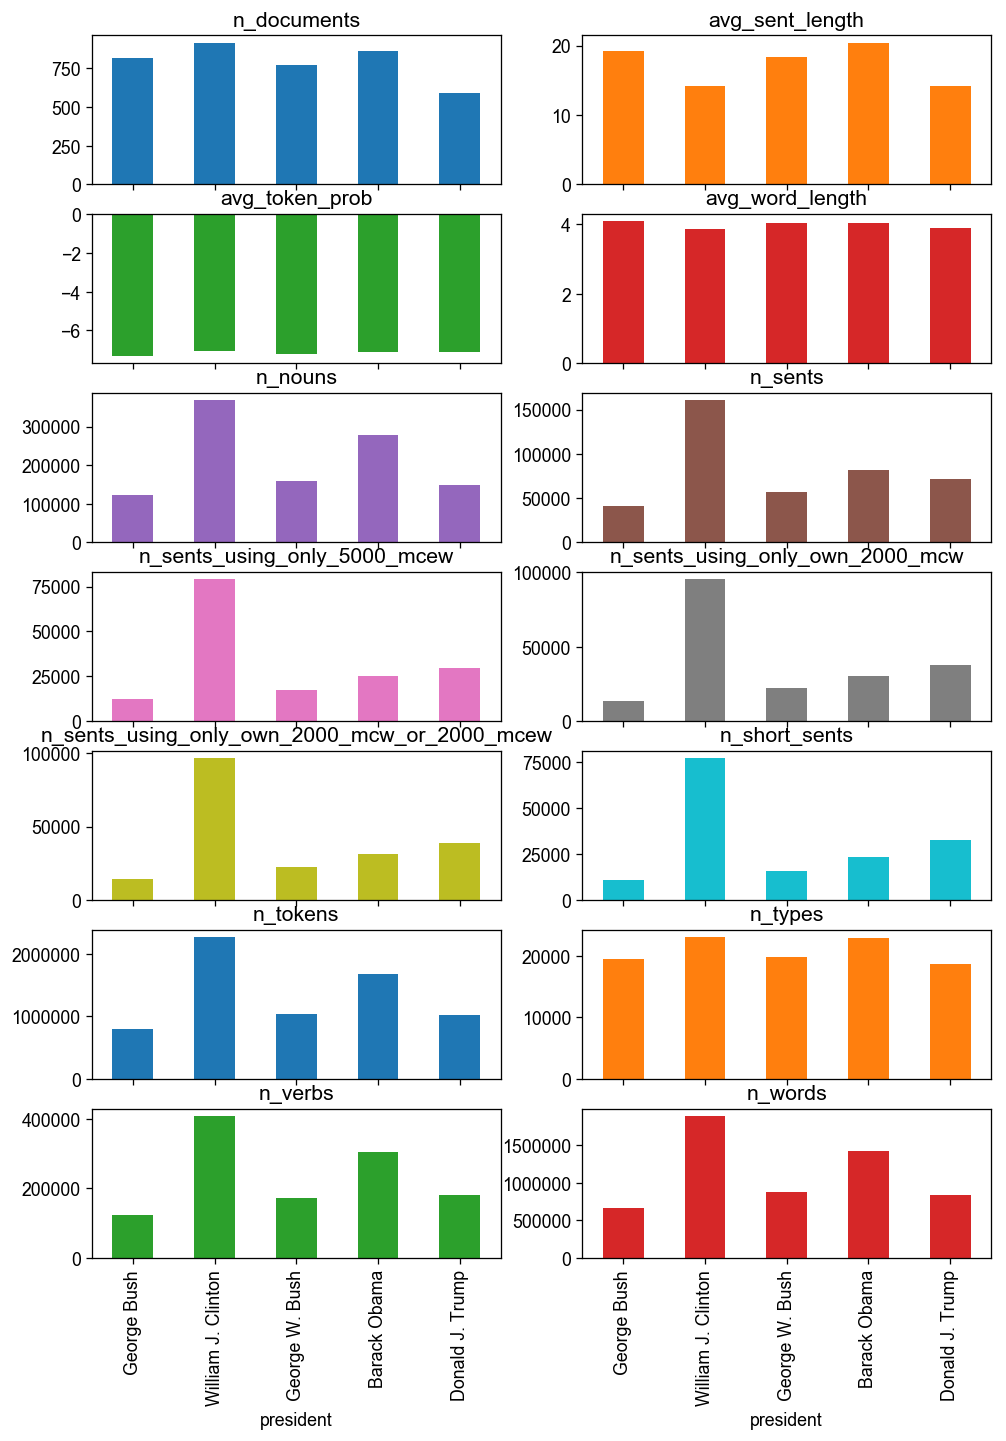

In [85]:
# df.plot(kind='bar')
# df.transpose().plot(kind='bar')
# def plot_columns(df):
#     ncols = 3
#     fig, axes = plt.subplots(4, ncols, sharex=True)
#     for i, column in enumerate(df.columns):
#         row = i // ncols
#         col = i % ncols
#         ax = axes[row, col]
#         df[column].plot(kind='bar', ax=ax)
#         ax.set_title(column)
#         ax.set_xlabel('')
df.plot(kind='bar', subplots=True, layout=(1 + len(df.columns) // 2, 2), legend=None, figsize=(10, 16));

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

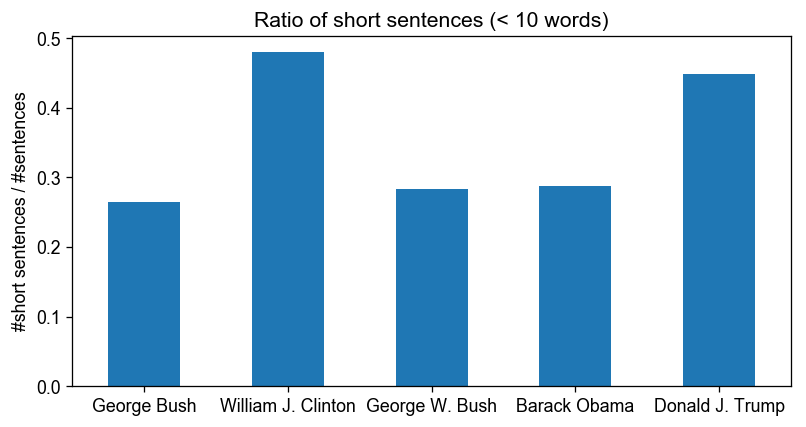

In [86]:
(df.n_short_sents / df.n_sents).plot(kind='bar', figsize=(8, 4))
plt.title('Ratio of short sentences (< 10 words)')
plt.ylabel('#short sentences / #sentences')
plt.xlabel('')
plt.xticks(rotation=0)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

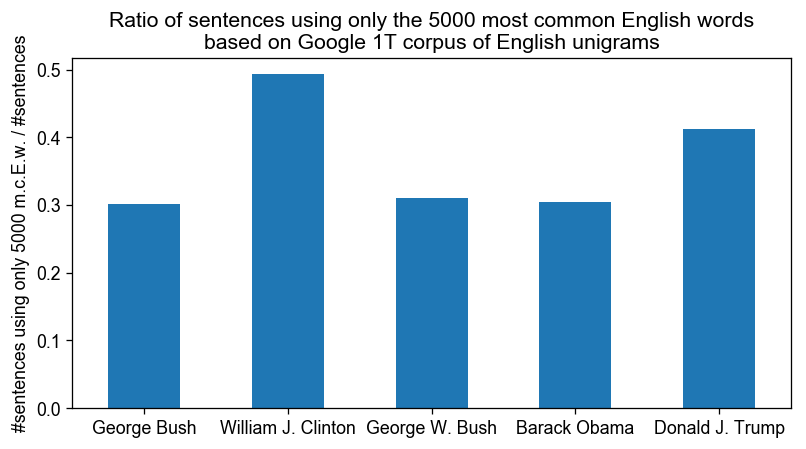

In [88]:
(df.n_sents_using_only_5000_mcew / df.n_sents).plot(kind='bar', figsize=(8, 4))
plt.title('''Ratio of sentences using only the 5000 most common English words
based on Google 1T corpus of English unigrams''')
plt.ylabel('#sentences using only 5000 m.c.E.w. / #sentences')
plt.xlabel('')
plt.xticks(rotation=0)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

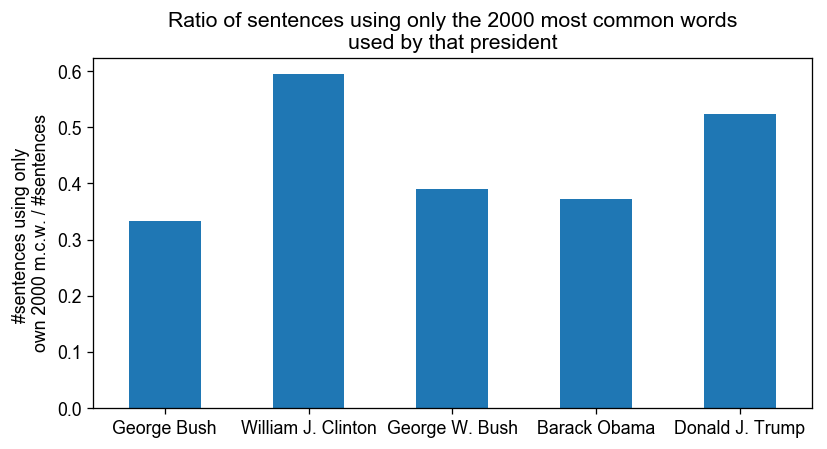

In [92]:
(df.n_sents_using_only_own_2000_mcw / df.n_sents).plot(kind='bar', figsize=(8, 4))
plt.title('''Ratio of sentences using only the 2000 most common words
used by that president''')
plt.ylabel('''#sentences using only 
own 2000 m.c.w. / #sentences''')
plt.xlabel('')
plt.xticks(rotation=0)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

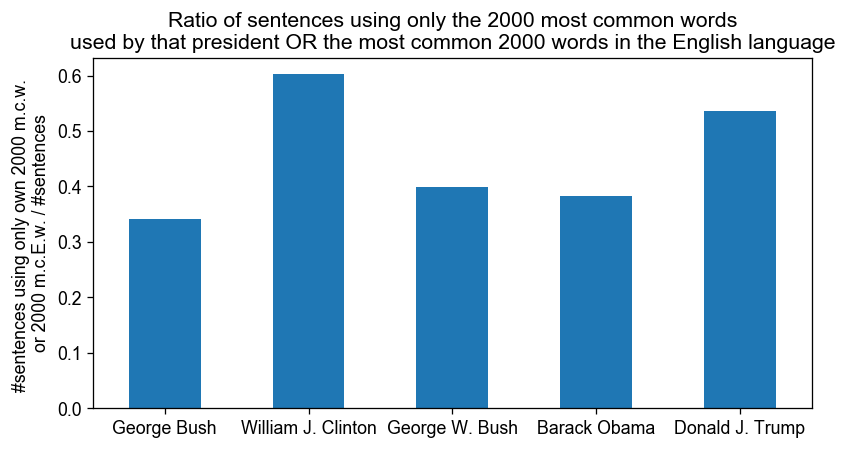

In [91]:
(df.n_sents_using_only_own_2000_mcw_or_2000_mcew / df.n_sents).plot(kind='bar', figsize=(8, 4))
plt.title('''Ratio of sentences using only the 2000 most common words
used by that president OR the most common 2000 words in the English language''')
plt.ylabel('''#sentences using only own 2000 m.c.w. 
or 2000 m.c.E.w. / #sentences''')
plt.xlabel('')
plt.xticks(rotation=0)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

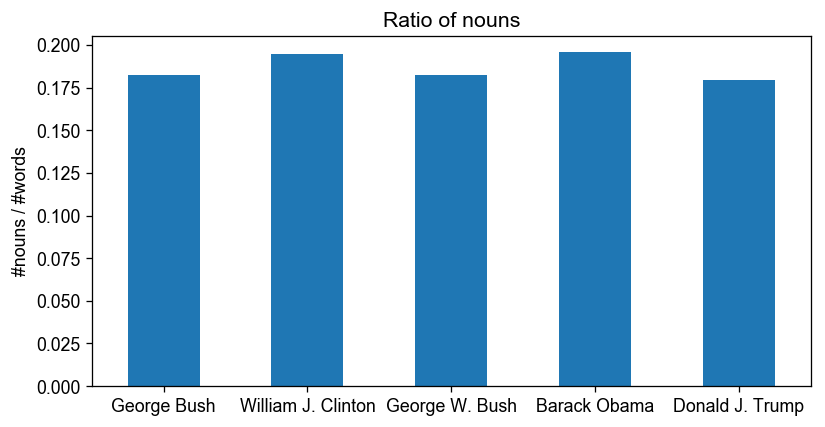

In [94]:
(df.n_nouns / df.n_words).plot(kind='bar', figsize=(8, 4))
plt.title('Ratio of nouns')
plt.ylabel('#nouns / #words')
plt.xlabel('')
plt.xticks(rotation=0)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

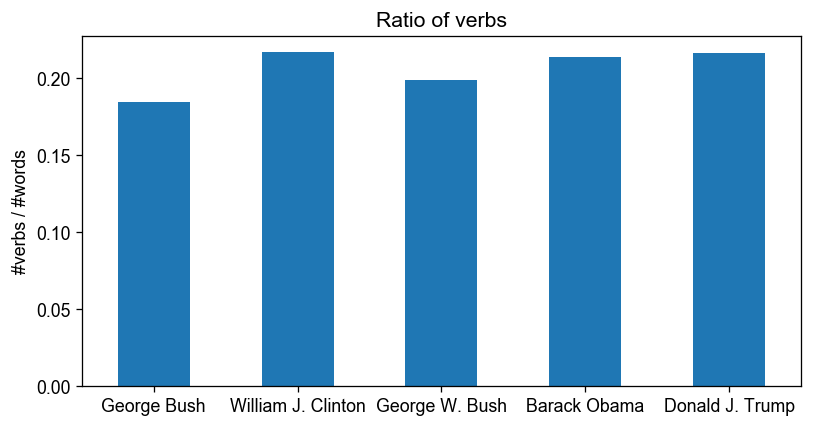

In [95]:
(df.n_verbs / df.n_words).plot(kind='bar', figsize=(8, 4))
plt.title('Ratio of verbs')
plt.ylabel('#verbs / #words')
plt.xlabel('')
plt.xticks(rotation=0)

## Us vs. them

In [96]:
us_tokens = 'us we our ourselves'.split()
us_re = re.compile(r'\b(us|we|our|ourselves)\b', re.I)
them_tokens = 'them they their themselves'.split()
them_re = re.compile(r'\b(them|they|their|themselves)\b', re.I)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

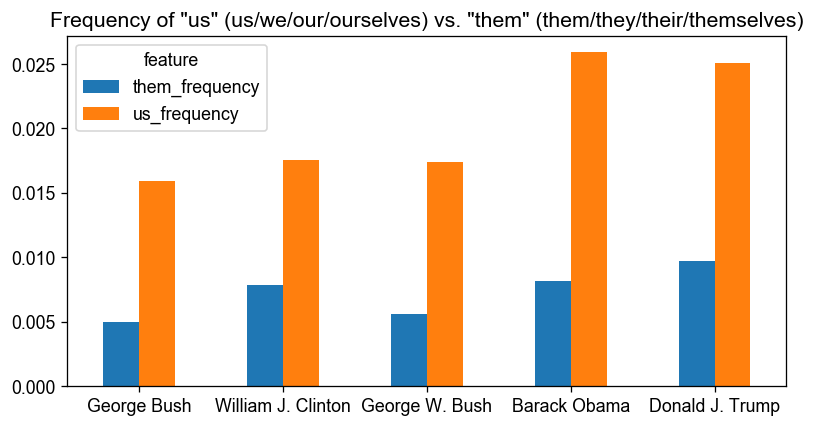

In [98]:
def _term_frequency(needle_tokens, haystack_doc):
    doc_token_counts = token_counts(haystack_doc)
    return sum(doc_token_counts.get(k, 0) for k in needle_tokens) / len(haystack_doc)

def us_frequency(doc):
    return _term_frequency(us_tokens, doc)
    
def them_frequency(doc):
    return _term_frequency(them_tokens, doc)

df_us_them = create_featurized_df([41, 42, 43, 44, 45], [us_frequency, them_frequency])
df = df_us_them.pivot_table(values='value', index=['president_id', 'president'], columns='feature').reset_index('president_id', drop=True)
df.plot(kind='bar', figsize=(8, 4))
plt.title('Frequency of "us" ({}) vs. "them" ({})'.format('/'.join(us_tokens), '/'.join(them_tokens)))
plt.xlabel('')
plt.xticks(rotation=0)

In [99]:
def _term_sentiment(haystack_doc, needle_re, preceding_window, subsequent_window):
    context_tokens_generator = context_tokens(haystack_doc, needle_re, preceding_window, subsequent_window)
    context_token_counts = Counter(token.lower_ for token in context_tokens_generator)
    scores = liwc_scores(context_token_counts)
    return scores['posemo'] - scores['negemo']

In [100]:
def create_us_them_sentiment_df(presidents, preceding_window, subsequent_window):
    def us_sentiment(doc):
        return _term_sentiment(doc, us_re, preceding_window, subsequent_window)
    def them_sentiment(doc):
        return _term_sentiment(doc, them_re, preceding_window, subsequent_window)
    return create_featurized_df(presidents, [us_sentiment, them_sentiment])

In [103]:
def plot_us_them_sentiment_df(presidents, window):
    df_us_them_sentiment = create_us_them_sentiment_df(presidents, window, window)
    df = df_us_them_sentiment.pivot_table(values='value', 
                                          index=['president_id', 'president'], 
                                          columns='feature').reset_index('president_id', drop=True)
    df.plot(kind='bar', figsize=(8, 4))
    plt.title('''Sentiment re: "us" ({}) vs. "them" ({})
    with {}-token windows'''.format('/'.join(us_tokens), '/'.join(them_tokens), window))
    plt.xlabel('')
    plt.xticks(rotation=0)
    plt.legend(loc='lower left')

CPU times: user 5min 37s, sys: 6.08 s, total: 5min 44s
Wall time: 5min 51s


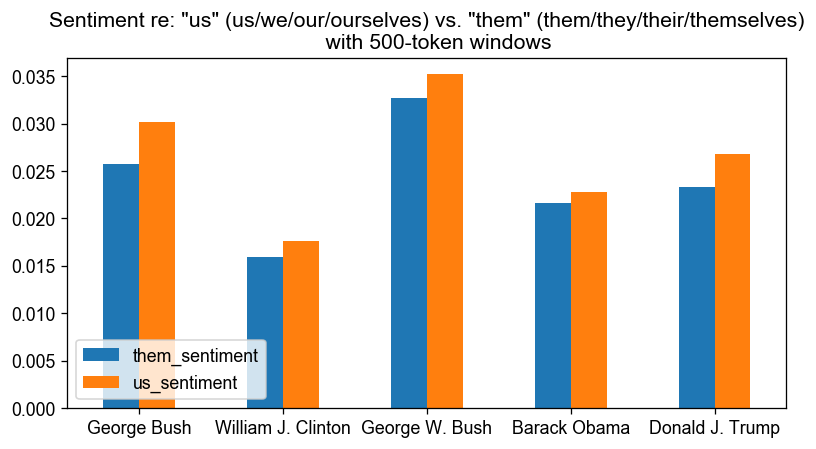

In [104]:
%%time
plot_us_them_sentiment_df([41, 42, 43, 44, 45], 500)

CPU times: user 1min 29s, sys: 2.73 s, total: 1min 32s
Wall time: 1min 33s


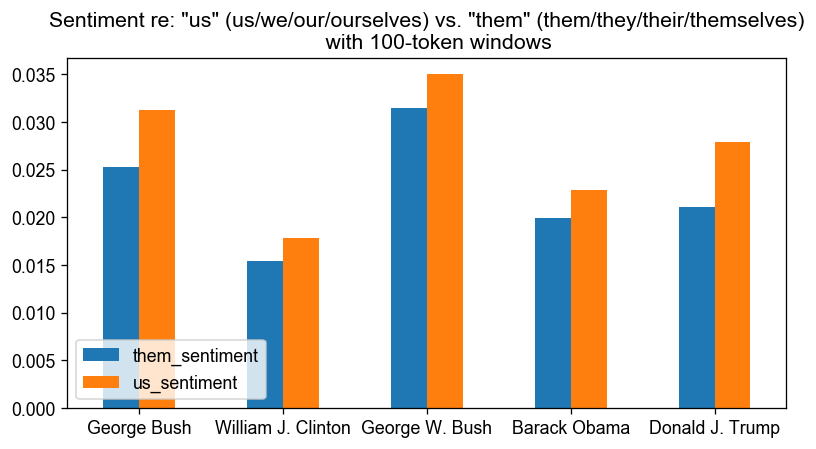

In [105]:
%%time
plot_us_them_sentiment_df([41, 42, 43, 44, 45], 100)

CPU times: user 41.3 s, sys: 2.07 s, total: 43.3 s
Wall time: 44.2 s


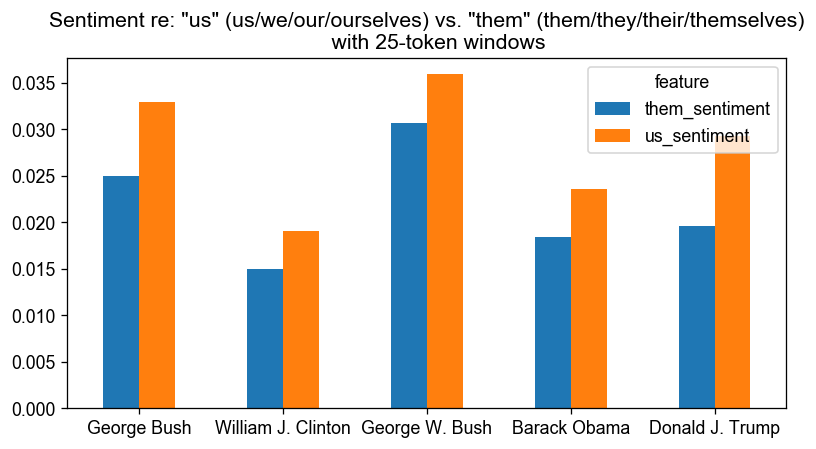

In [102]:
%%time
plot_us_them_sentiment_df([41, 42, 43, 44, 45], 25)

CPU times: user 33.1 s, sys: 1.43 s, total: 34.6 s
Wall time: 35 s


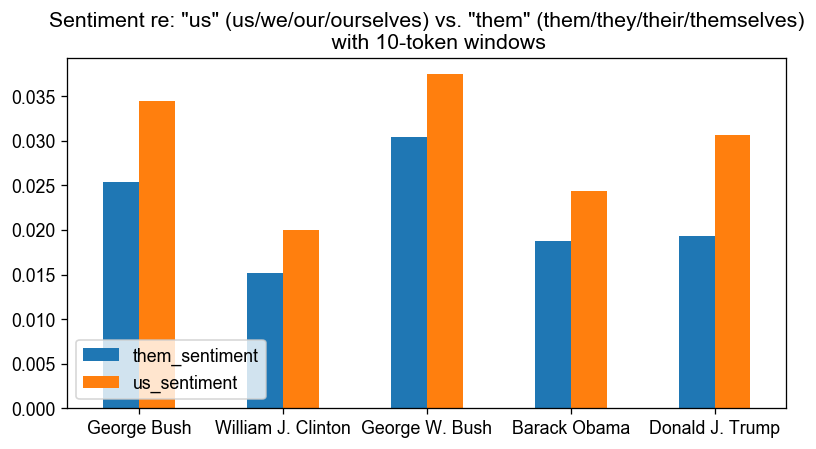

In [106]:
%%time
plot_us_them_sentiment_df([41, 42, 43, 44, 45], 10)

CPU times: user 27.2 s, sys: 1.47 s, total: 28.7 s
Wall time: 29.5 s


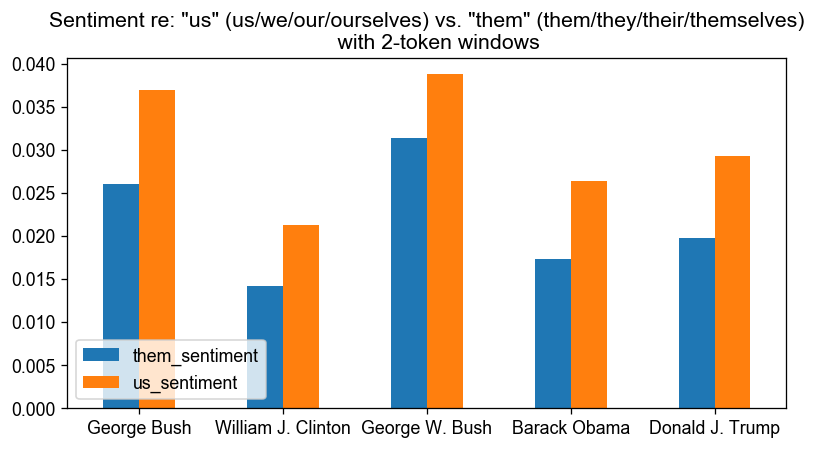

In [107]:
%%time
plot_us_them_sentiment_df([41, 42, 43, 44, 45], 2)

CPU times: user 26.6 s, sys: 1.33 s, total: 28 s
Wall time: 27.8 s


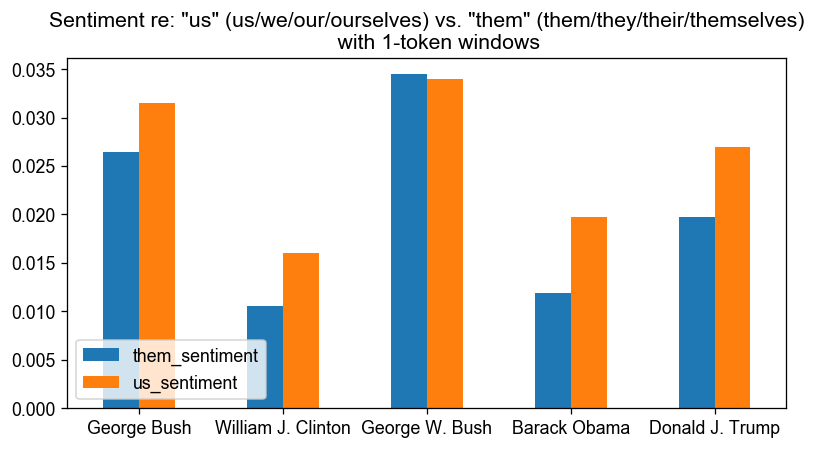

In [108]:
%%time
plot_us_them_sentiment_df([41, 42, 43, 44, 45], 1)

In [109]:
def create_context_string_df(presidents, needle_re, window):
    def iter_rows():
        for president in presidents:
            name = presidents_lookup[president]
            doc = load_president_doc(president)
            for preceding_span, match_span, subsequent_span in context_spans(doc, needle_re, window, window):
                yield president, name, preceding_span.text, match_span.text, subsequent_span.text
    return pd.DataFrame(iter_rows(), columns=['president_id', 'president', 'pre', 'match', 'post'])

create_context_string_df([44, 45], them_re, 10).set_index(['president_id', 'president']).reset_index('president_id', drop=True)

,pre,match,post
president,,,
Barack Obama,"are finding it impossible to get loans, which means",they,can't buy new equipment or make payroll. Auto
Barack Obama,Auto plants that have been around for decades are closing,their,doors and laying off workers who've never known another
Barack Obama,laying off workers who've never known another job in,their,entire life. And we have already lost three-
Barack Obama,gas tank and some people don't even know whether,they,'ll be able to keep the electricity on at the
Barack Obama,jobs and take the last bus home at night because,they,want something more for their children. We're still
Barack Obama,bus home at night because they want something more for,their,children. We're still the home to innovation and
Barack Obama,say his plan would cause 20 million Americans to lose,their,"health insurance, or how the Chamber of Commerce said"
Barack Obama,it would de-regulate the insurance industry so that,they,"don't have to cover things like mammograms, or"
Barack Obama,"a hospital bed, fighting with her insurance company because",they,claimed that her cancer was a pre-existing condition


## Repetition

In [112]:
def count_repetitions(tokens, window_size):
    unigram_repetitions = 0
    bigram_repetitions = 0
    for window_tokens in sliding_window(window_size, tokens):
        unigram_needle = window_tokens[-1]
        bigram_needle = window_tokens[-2:]
        if unigram_needle in window_tokens[:-1]:
            unigram_repetitions += 1
        window_bigrams = list(sliding_window(2, window_tokens[:-2]))
        if bigram_needle in window_bigrams:
            bigram_repetitions += 1
    return unigram_repetitions, bigram_repetitions

In [113]:
def create_repetition_df(presidents, window_size):
    def iter_rows():
        for president in presidents:
            name = presidents_lookup[president]
            doc = load_president_doc(president)
            token_strings = [token.lower_ for token in doc]
            unigram_repetitions, bigram_repetitions = count_repetitions(token_strings, window_size)
            yield president, name, len(doc), unigram_repetitions, bigram_repetitions
    return pd.DataFrame(iter_rows(), columns=['president_id', 'president', 'n_tokens', 
                                              'n_unigram_repetitions', 'n_bigram_repetitions'])

In [114]:
def plot_repetition_df(presidents, window_size):
    df_repetition = create_repetition_df(presidents, window_size)
    df = df_repetition.set_index(['president_id', 'president']).reset_index('president_id', drop=True)
    df['unigram_repetitions/token'] = df.n_unigram_repetitions / df.n_tokens
    df['bigram_repetitions/token'] = df.n_bigram_repetitions / df.n_tokens
    df[['unigram_repetitions/token', 'bigram_repetitions/token']].transpose().plot(kind='bar')
    plt.title('Proportion of unigram and bigram repetitions in a {}-word sliding window'.format(window_size))
    plt.xlabel('')
    plt.ylabel('#repetitions / #tokens')
    plt.xticks(rotation=0)
    return df

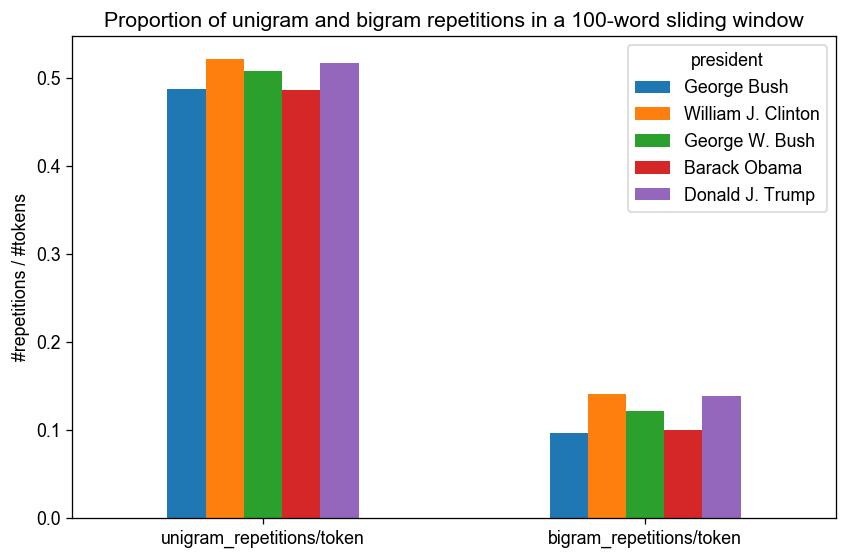

In [116]:
df_repetition_100 = plot_repetition_df([41, 42, 43, 44, 45], 100)

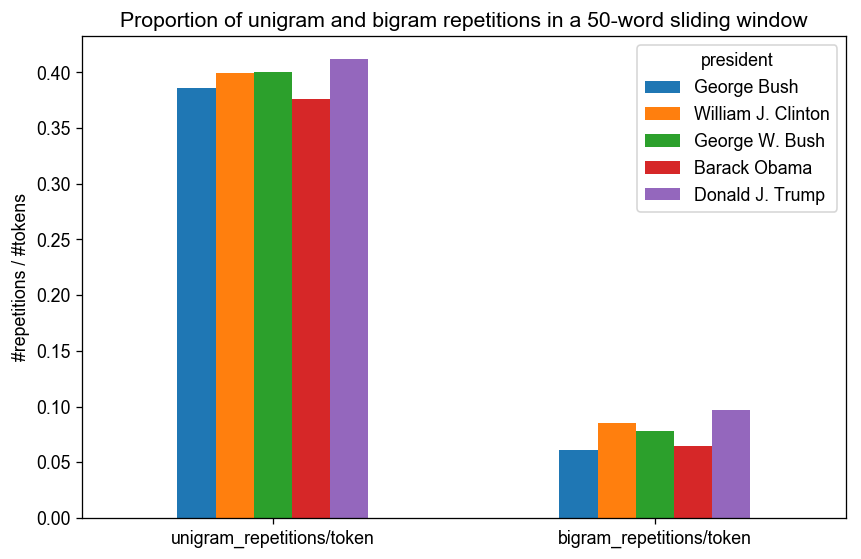

In [117]:
df_repetition_50 = plot_repetition_df([41, 42, 43, 44, 45], 50)

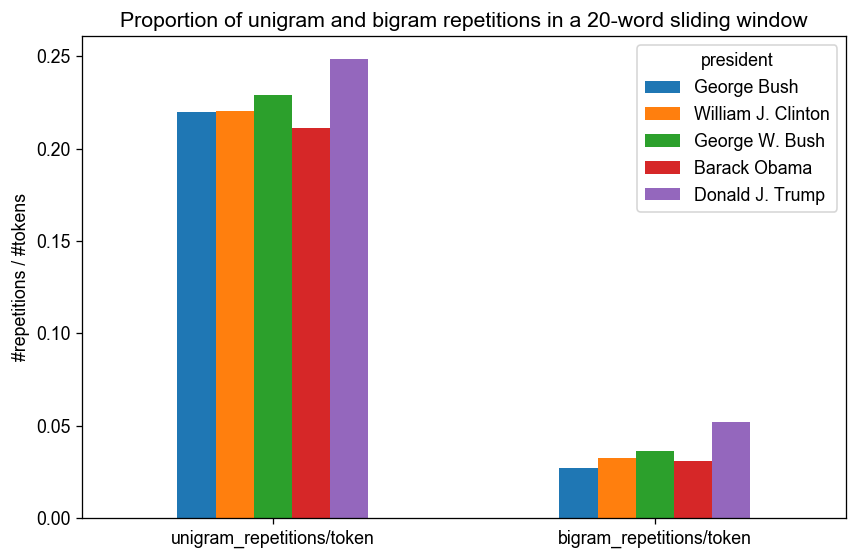

In [115]:
df_repetition_20 = plot_repetition_df([41, 42, 43, 44, 45], 20)

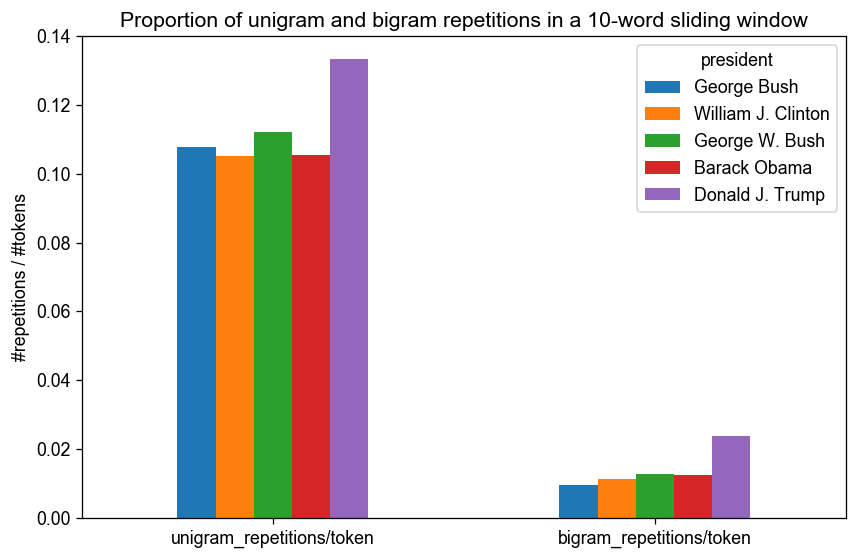

In [118]:
df_repetition_10 = plot_repetition_df([41, 42, 43, 44, 45], 10)